## Compute Sagnac Frequency - Prism Spectra - RV

Westring was equipped with a Koester prism at the central shaft using the new prism mount with micrometer screws. Simultaneous recording with discrete combination (RV logging) and Koester prism (RW logging)

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read_inventory
from numpy import log10

from andbro__savefig import __savefig


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# from matplotlib import rc
# rc('text', usetex=True)

## Configurations

In [4]:
config = {}


config['seeds'] = ["BW.DROMY..FJV", "BW.DROMY..FJW"]

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-10-23 23:30")
config['tend'] = UTCDateTime("2023-10-23 23:50")

## 10min with local signal
config['tbeg'] = UTCDateTime("2023-10-27 00:00")
config['tend'] = UTCDateTime("2023-10-27 00:10")

## 10min noise only
config['tbeg'] = UTCDateTime("2023-10-27 16:45")
config['tend'] = UTCDateTime("2023-10-27 16:55")

## 
config['tbeg'] = UTCDateTime("2023-10-27 15:00")
config['tend'] = UTCDateTime("2023-10-27 17:00")

config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

config['datapath'] = data_path+"sagnac_frequency/prismspectra/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [5]:
def __compute_psd(st0, twin_sec=60):

    from scipy.signal import welch, hann

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

## Load Raw data

In [6]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

 -> loading BW.DROMY..FJV...
 -> loading BW.DROMY..FJW...


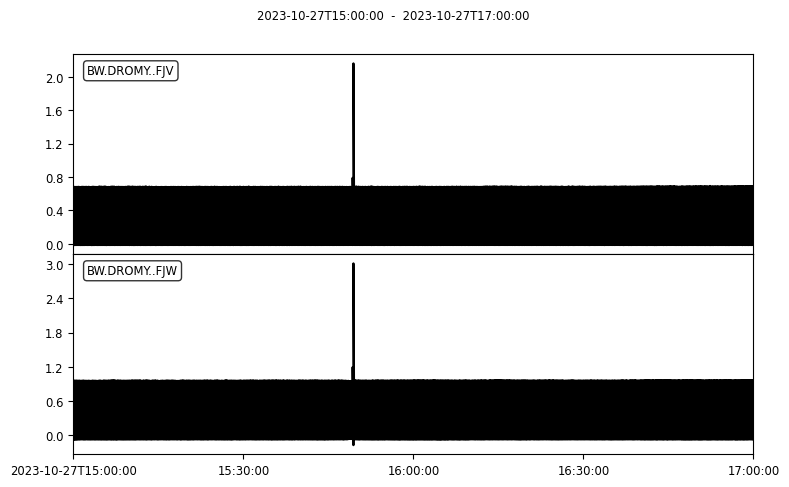

In [7]:
st = __load_romy_raw_data(config['seeds'], config['tbeg'], config['tend'], config['path_to_sds'])

# st.detrend("demean")

st.plot(equal_scale=False);

In [ ]:
st.select(channel="FJW").write("/home/andbro/Downloads/4Jan/westring_koester.csv", format="TSPAIR")
st.select(channel="FJV").write("/home/andbro/Downloads/4Jan/westring_discrete.csv", format="TSPAIR")

In [ ]:
def __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann
    import matplotlib.pyplot as plt


    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = hann(nblock, True)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        # tr.data /= max(abs(tr.data))

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'U (volt)')

        axes[i,1].set_ylabel(r'PSD (volt$^2$/Hz)')

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)
        # axes[i,1].set_ylim(top=0)

    plt.show();
    return fig, (Pxxs, ffs, chs)

In [ ]:
fig, out = __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=config['f_lower_zoomin'], f_upper_zoom=config['f_upper_zoomin'])

fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_trace&PSD.png", format="png", dpi=200, bbox_inches='tight')

## Plot Comparison

In [ ]:
def __makeplot_psd_overview_with_zoomin(stx, twin_sec=60, plot_dB=True):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from numpy import log10

    font = 14

    # stx = stx.detrend("demean")
    # stx = stx.normalize()

    out = __compute_psd(stx, twin_sec=twin_sec)

    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])


    for jj in range(len(Pxxs)):
        if plot_dB:
            ax1.semilogx(ffs[jj], 10*log10(Pxxs[jj]) - max(10*log10(Pxxs[jj])), alpha=0.5, label=chs[jj])
            ax2.plot(ffs[jj], 10*log10(Pxxs[jj]) - max(10*log10(Pxxs[jj])), alpha=0.5, label=chs[jj])
            ax1.set_ylim(-110, 0)
            ax2.set_ylim(-110, 0)
        else:
            ax1.loglog(ffs[1], Pxxs[1], alpha=0.5, label=chs[1])
            ax2.loglog(ffs[1], Pxxs[1], alpha=0.5, label=chs[1])

    # ax1.semilogx(ffs[2], 20*log10(Pxxs[2]), alpha=0.5, color="tab:green", label=chs[2], zorder=2)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)



    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    ax2.set_xlim(config['f_lower_zoomin'], config['f_upper_zoomin'])
    ax2.set_xlim(447.4, 447.55)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax1.set_title(f"{stx[0].stats.starttime.date} {time_str}")

    plt.show();
    return fig

In [ ]:
fig = __makeplot_psd_overview_with_zoomin(st, twin_sec=1200, plot_dB=True)

# fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_zoomin.png", format="png", dpi=200, bbox_inches='tight')

In [ ]:
from andbro__read_sds import __read_sds

In [ ]:
romy = __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg'], config['tend'])

romy_inv = read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless.seed.BW_ROMY")

romy = romy.remove_sensitivity(romy_inv)

romy = romy.detrend("demean")

In [ ]:
def __makeplot2(st0, stx, twin_sec=30, plot_dB=True):


    out = __compute_psd(stx, twin_sec=twin_sec)

    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

    fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.25)

    font = 12

    ax[0].plot(st0[0].times()/60, st0[0].data*1e9, color="k")
    ax[0].set_xlim(0, max(st0[0].times()/60))
    ax[0].set_xlabel("Time (min)", fontsize=font)
    ax[0].set_ylabel("$\Omega$ (nrad/s)", fontsize=font)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax[0].set_title(f"{stx[0].stats.starttime.date} {time_str}")


    for jj in range(len(Pxxs)):
        if plot_dB:
            ax[1].semilogx(ffs[jj], 10*log10(Pxxs[jj]) - max(10*log10(Pxxs[jj])), alpha=0.5, label=chs[jj])
            ax[2].plot(ffs[jj], 10*log10(Pxxs[jj]) - max(10*log10(Pxxs[jj])), alpha=0.5, label=chs[jj])
            ax[1].set_ylim(-110, 0)
            ax[2].set_ylim(-110, 0)
        else:
            ax[1].loglog(ffs[1], Pxxs[1], alpha=0.5, label=chs[1])
            ax[2].loglog(ffs[1], Pxxs[1], alpha=0.5, label=chs[1])

    ax[1].grid(alpha=0.2, which="both")
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    ax[1].legend(loc="upper center", fontsize=font-1, ncol=3)
    ax[1].tick_params(labelsize=font-2)



    ax[2].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[2].grid(alpha=0.2, which="both")
    ax[2].tick_params(labelsize=font-2)
    ax[2].set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)

    ax[2].set_xlim(config['f_lower_zoomin'], config['f_upper_zoomin'])

    ax[0].text(.01, .97, '(a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
    ax[2].text(.01, .97, '(c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot2(romy, st, twin_sec=1200, plot_dB=True)

fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_rotation_spectra.png", format="png", dpi=200, bbox_inches='tight')

## Load PSD Data

data1 = discrete combination in north western corner

data2 = Koester prism on new prism stage in central corner

In [ ]:
data1 = read_pickle(config['datapath']+"psd_2023-10-18_RV_westring_discrete.pkl")
data2 = read_pickle(config['datapath']+"psd_2023-10-18_RV_westring_koester.pkl")

## add DB psds
data1['fjz_psd_db'] = 20*log10(data1.fjz_psd)
data2['fjz_psd_db'] = 20*log10(data2.fjz_psd)

In [ ]:
def __makeplot(data1, data2, plot_dB=True):

    from matplotlib.gridspec import GridSpec

    font = 14


    fig = plt.figure(figsize=(15,8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])

    if plot_dB:
        ax1.semilogx(data1.frequencies, data1.fjz_psd_db, alpha=0.5, color="tab:blue", label="inv. discrete beam combiner")
        ax1.semilogx(data2.frequencies, data2.fjz_psd_db, alpha=0.5, color="tab:orange", label="inv. Koester prism")
        ax1.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    else:
        ax1.semilogx(data1.frequencies, data1.fjz_psd, alpha=0.5, color="tab:blue", label="inv. discrete beam combiner")
        ax1.semilogx(data2.frequencies, data2.fjz_psd, alpha=0.5, color="tab:orange", label="inv. Koester prism")
        ax1.set_ylabel(f"PSD ($V^2$/Hz)", fontsize=font)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1)
    ax1.tick_params(labelsize=font-2)

    # ax1.set_ylim(-230, 50)


    ax2 = fig.add_subplot(gs[1])

    if plot_dB:
        ax2.plot(data1.frequencies, data1.fjz_psd_db, alpha=0.5, color="tab:blue")
        ax2.plot(data2.frequencies, data2.fjz_psd_db, alpha=0.5, color="tab:orange")
    else:
        ax2.plot(data1.frequencies, data1.fjz_psd, alpha=0.5, color="tab:blue")
        ax2.plot(data2.frequencies, data2.fjz_psd, alpha=0.5, color="tab:orange")

    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    ax2.set_xlim(448-30, 448+30)
   # ax2.set_ylim(-230, 50)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)


    plt.show();
    return fig

# fig = __makeplot(data1, data2, plot_dB=True)

In [ ]:
def __makeplot():

    font = 12

    fig, ax = plt.subplots(3,2,figsize=(15,10))

    ax[0,0].loglog(data1.frequencies, data1.fjz_psd, alpha=0.5, label="before")
    ax[0,0].loglog(data1.frequencies, data1.fjz_psd, alpha=0.5, label="after")
    # ax[0,0].loglog(noise1.frequencies, noise1.fjz_psd, alpha=0.5, label="selfnoise", color="grey")

    ax[1,0].loglog(before.frequencies, before.f1v_psd, alpha=0.5, label="before")
    ax[1,0].loglog(before.frequencies, after.f1v_psd, alpha=0.5, label="after")

    ax[2,0].loglog(before.frequencies, before.f2v_psd, alpha=0.5, label="before")
    ax[2,0].loglog(before.frequencies, after.f2v_psd, alpha=0.5, label="after")

    ax[0,1].semilogy(before.frequencies, before.fjz_psd, alpha=0.5, label="before")
    ax[0,1].semilogy(before.frequencies, after.fjz_psd, alpha=0.5, label="after")
    ax[0,1].semilogy(noise1.frequencies, noise1.fjz_psd, alpha=0.5, label="selfnoise", color="grey")

    ax[1,1].semilogy(before.frequencies, before.f1v_psd, alpha=0.5, label="before")
    ax[1,1].semilogy(before.frequencies, after.f1v_psd, alpha=0.5, label="after")

    ax[2,1].semilogy(before.frequencies, before.f2v_psd, alpha=0.5, label="before")
    ax[2,1].semilogy(before.frequencies, after.f2v_psd, alpha=0.5, label="after")


    for i in range(3):
        ax[i,1].set_xlim(553-30, 553+30)
        ax[i,0].legend(loc=2)
        ax[i,1].legend(loc=2)
        ax[i,0].grid(zorder=-1, alpha=0.2)
        ax[i,1].grid(zorder=-1, alpha=0.2)
    #     ax[i].ticklabel_format(useOffset=False, style='plain')


    ax[0,0].set_ylabel("PSD FZ ($V^2 / Hz$)", fontsize=font)
    ax[1,0].set_ylabel("PSD CCW ($V^2 / Hz$)", fontsize=font)
    ax[2,0].set_ylabel("PSD CW ($V^2 / Hz$)", fontsize=font)

    ax[2,0].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[2,1].set_xlabel("Frequency (Hz)", fontsize=font)

    plt.show();

# __makeplot()

In [ ]:
def __makeplot_DB():

    font = 12

    fig, ax = plt.subplots(3,2,figsize=(15,10))

    plt.subplots_adjust(wspace=0.1)

    ax[0,0].semilogx(data1.frequencies, data1.fjz_psd_db, alpha=0.5, label="discrete combiner")
    ax[0,0].semilogx(data2.frequencies, data2.fjz_psd_db, alpha=0.5, label="after prism")

    ax[1,0].semilogx(before.frequencies, before.f1v_psd_db, alpha=0.5, label="discrete combiner")
    ax[1,0].semilogx(before.frequencies, after.f1v_psd_db, alpha=0.5, label="Koester prism")

    ax[2,0].semilogx(before.frequencies, before.f2v_psd_db, alpha=0.5, label="discrete combiner")
    ax[2,0].semilogx(before.frequencies, after.f2v_psd_db, alpha=0.5, label="Koester prism")

    ax[0,1].plot(before.frequencies, before.fjz_psd_db, alpha=0.5, label="discrete combiner")
    ax[0,1].plot(before.frequencies, after.fjz_psd_db, alpha=0.5, label="Koester prism")

    ax[1,1].plot(before.frequencies, before.f1v_psd_db, alpha=0.5, label="discrete combiner")
    ax[1,1].plot(before.frequencies, after.f1v_psd_db, alpha=0.5, label="Koester prism")

    ax[2,1].plot(before.frequencies, before.f2v_psd_db, alpha=0.5, label="discrete combiner")
    ax[2,1].plot(before.frequencies, after.f2v_psd_db, alpha=0.5, label="Koester prism")


    for i in range(3):
        ax[i,1].set_xlim(553-30, 553+30)
        ax[i,0].legend(loc=2)
        ax[i,1].legend(loc=2)
        ax[i,0].grid(zorder=-1, alpha=0.2, which="both")
        ax[i,1].grid(zorder=-1, alpha=0.2, which="both")


    for i in range(3):
        for j in range(2):
            ax[i,j].set_ylim(-200,50)

    #     ax[i].ticklabel_format(useOffset=False, style='plain')


    ax[0,0].set_ylabel(f"PSD FZ \n (dB rel.to (1 $V^2 / Hz$))", fontsize=font)
    ax[1,0].set_ylabel(f"PSD CCW \n (dB rel.to (1 $V^2 / Hz$))", fontsize=font)
    ax[2,0].set_ylabel(f"PSD CW \n (dB rel.to (1 $V^2 / Hz$))", fontsize=font)

    ax[2,0].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[2,1].set_xlabel("Frequency (Hz)", fontsize=font)

    plt.show();

# __makeplot_DB()